In [4]:
#an example of GVCL converging to EWC for small beta values on logistic regression
#this is the example in Appendix B

import torch
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda:0'

In [5]:
np.random.seed(0)
x1 = np.concatenate([np.random.multivariate_normal([-2, -1], 0.8 * np.eye(2), 100), np.random.multivariate_normal([2, 1], 0.8 * np.eye(2), 100)])
y1 = np.concatenate([[0] * 100, [1]*100])

x2 = np.concatenate([np.random.multivariate_normal([-2, 2], 0.8 * np.eye(2), 100), np.random.multivariate_normal([2, -2], 0.8 * np.eye(2), 100)])
y2 = np.concatenate([[0] * 100, [1]*100])

Text(0.5, 1.0, 'Combined')

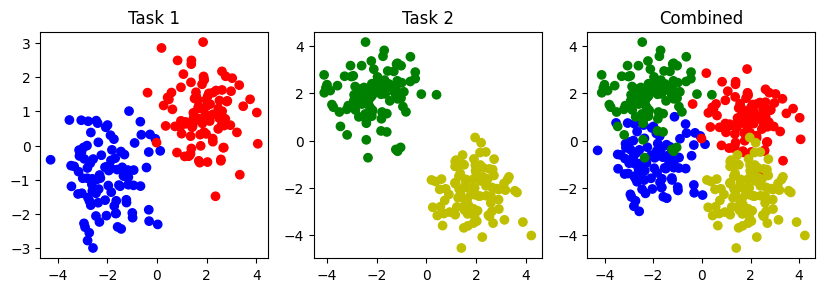

In [6]:
fig, ax = plt.subplots(1, 3, dpi = 100, figsize = (10, 3))
ax[0].scatter(x1[:, 0], x1[:, 1], c = ['b' if lab == 0 else 'r' for lab in y1])
ax[2].scatter(x1[:, 0], x1[:, 1], c = ['b' if lab == 0 else 'r' for lab in y1])
ax[1].scatter(x2[:, 0], x2[:, 1], c = ['g' if lab == 0 else 'y' for lab in y2])
ax[2].scatter(x2[:, 0], x2[:, 1], c = ['g' if lab == 0 else 'y' for lab in y2])
ax[0].set_title('Task 1')
ax[1].set_title('Task 2')
ax[2].set_title('Combined')

In [7]:
def compute_kl(m1, v1, m2, v2, map = False):
    d = m1.numel()
    log_det_term = torch.sum(v2) - torch.sum(v1)
    mean_term = torch.sum((m1-m2)**2/torch.exp(v2))
    trace_term = torch.sum(torch.exp(v1-v2))
    
    if not map:
        return 0.5 * (log_det_term + mean_term + trace_term - d)
    else:
        return 0.5 * (mean_term)

In [8]:
global w_mean, b_mean, w_log_var, b_log_var, w_prior_mean, b_prior_mean, w_prior_log_var, b_prior_log_var

w_mean = torch.nn.Parameter(torch.empty([2], device = device, dtype = torch.double))
b_mean = torch.nn.Parameter(torch.empty([], device = device, dtype = torch.double))


w_log_var = torch.nn.Parameter(torch.empty([2], device = device, dtype = torch.double))
b_log_var = torch.nn.Parameter(torch.empty([], device = device, dtype = torch.double))

torch.nn.init.normal_(w_mean, -2)
torch.nn.init.normal_(b_mean, -2)
torch.nn.init.constant_(w_log_var, -2)
torch.nn.init.constant_(b_log_var, -2)

w_prior_mean = torch.zeros_like(w_mean)
b_prior_mean = torch.zeros_like(b_mean)

w_prior_log_var = torch.zeros_like(w_log_var)
b_prior_log_var = torch.zeros_like(b_log_var)

params_vi = [w_mean, b_mean, w_log_var, b_log_var]

def fit_map(x, y, fish_penalty = False, niters = 40000):
    optim = torch.optim.Adam([w_mean, b_mean], 1e-3)
    
    xc = torch.from_numpy(x).to(device)
    yc = torch.from_numpy(y).to(device).double()
            
    for i in range(niters):
        optim.zero_grad()
        logits = (xc @ w_mean[None, :].T  + b_mean).flatten()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, yc)
        
        if fish_penalty:
            loss += compute_kl(w_mean, w_log_var, w_prior_mean, w_prior_log_var)
            loss += compute_kl(b_mean, b_log_var, b_prior_mean, b_prior_log_var)
        
        loss.backward()
        optim.step()

def fit_vi(x, y, beta = 1, niters = 40000):
    n_samples = 20
    optim = torch.optim.Adam([w_mean, b_mean, w_log_var, b_log_var], 1e-3)
    
    xc = torch.from_numpy(x).to(device)
    yc = torch.from_numpy(y).to(device).double()
    
    for i in range(niters):
        optim.zero_grad()
        
        w_samples = w_mean[None] + torch.empty((n_samples, xc.shape[0], xc.shape[1]), device = device).normal_() * torch.exp(0.5 * w_log_var)
        b_samples = b_mean[None] + torch.empty((n_samples, xc.shape[0]), device = device).normal_() * torch.exp(0.5 * b_log_var)
        
        x_stacked = xc[None, :, :].repeat(n_samples, 1, 1)
        y_stacked = yc[None, :].repeat(n_samples, 1)
        
        logits = torch.einsum('nbi, nbi -> nb', w_samples, x_stacked) + b_samples
        
        
        log_lik = torch.nn.functional.binary_cross_entropy_with_logits(logits.flatten(), y_stacked.flatten(), reduction = 'sum')/n_samples
        
#         if(i % 500 == 0):
#             print(log_lik)
        
        kl = compute_kl(w_mean, w_log_var, w_prior_mean, w_prior_log_var)
        kl += compute_kl(b_mean, b_log_var, b_prior_mean, b_prior_log_var)
        
        loss = log_lik + beta * kl
        
        loss.backward()
        optim.step()

def update_prior():
    w_prior_mean.data = w_mean.clone().detach()
    b_prior_mean.data = b_mean.clone().detach()
    
    w_prior_log_var.data = w_log_var.clone().detach()
    b_prior_log_var.data = b_log_var.clone().detach()
    
def update_fish(x, y):
    global w_mean, b_mean, w_log_var, b_log_var, w_prior_mean, b_prior_mean, w_prior_log_var, b_prior_log_var
    
    xc = torch.from_numpy(x).to(device)
    yc = torch.from_numpy(y).to(device)
    
    w_fish = torch.zeros_like(w_mean)
    b_fish = torch.zeros_like(b_mean)
    
    for x_sample in xc:
        logit = torch.sum(w_mean * x_sample) + b_mean
        prob = torch.sigmoid(logit)
        
        #for y = 1 prediction
        log_prob_deriv = 1 - prob
        w_grad = log_prob_deriv * x_sample
        b_grad = log_prob_deriv
        
        w_fish += prob * w_grad**2
        b_fish += prob * b_grad**2
        
        
        #for y = 0 prediction
        log_prob_deriv = prob
        w_grad = log_prob_deriv * x_sample
        b_grad = log_prob_deriv
        
        w_fish += (1 - prob) * w_grad**2
        b_fish += (1 - prob) * b_grad**2
        
    
    
    w_prior_mean.data = w_mean.clone().detach()
    b_prior_mean.data = b_mean.clone().detach()

    w_prior_log_var.data = -torch.log(w_fish/x.shape[0])
    b_prior_log_var.data = -torch.log(b_fish/x.shape[0])

def reset_prior():
    global w_mean, b_mean, w_log_var, b_log_var, w_prior_mean, b_prior_mean, w_prior_log_var, b_prior_log_var
    
    w_prior_mean = torch.zeros_like(w_mean)
    b_prior_mean = torch.zeros_like(b_mean)

    w_prior_log_var = torch.zeros_like(w_log_var)
    b_prior_log_var = torch.zeros_like(b_log_var)

In [9]:
def reset_parameters(seed):
    global w_mean, b_mean, w_log_var, b_log_var, w_prior_mean, b_prior_mean, w_prior_log_var, b_prior_log_var
    torch.manual_seed(seed)
    w_mean = torch.nn.Parameter(torch.empty([2], device = device, dtype = torch.double))
    b_mean = torch.nn.Parameter(torch.empty([], device = device, dtype = torch.double))


    w_log_var = torch.nn.Parameter(torch.empty([2], device = device, dtype = torch.double))
    b_log_var = torch.nn.Parameter(torch.empty([], device = device, dtype = torch.double))

    torch.nn.init.normal_(w_mean)
    torch.nn.init.normal_(b_mean)
    torch.nn.init.constant_(w_log_var, -2)
    torch.nn.init.constant_(b_log_var, -2)

In [10]:
def get_slope_intercept_map(niters = 40000, seed = 0):
    reset_parameters(seed)
    reset_prior()

    fit_map(x1, y1, niters = niters)
    w_np = w_mean.clone().detach().cpu().numpy()
    b_np = b_mean.clone().detach().cpu().numpy()
    slope = -w_np[0]/w_np[1]
    intercept = -b_np/w_np[1]
    x_boundary = np.linspace(-3, 3, 100)
    y_boundary = slope * x_boundary + intercept

    update_fish(x1, y1)


    fit_map(x2, y2, fish_penalty = True, niters = niters)
    w_np = w_mean.clone().detach().cpu().numpy()
    b_np = b_mean.clone().detach().cpu().numpy()
    slope = -w_np[0]/w_np[1]
    intercept = -b_np/w_np[1]
    x_boundary = np.linspace(-3, 3, 100)
    y_boundary = slope * x_boundary + intercept

    return np.concatenate([[slope], [intercept], w_np, [b_np]])


def get_slope_intercept_vi(beta = 1, niters = 40000, seed = 0):
    reset_parameters(seed)
    reset_prior()

    fit_vi(x1, y1, beta = beta, niters = niters)
    w_np = w_mean.clone().detach().cpu().numpy()
    b_np = b_mean.clone().detach().cpu().numpy()
    slope = -w_np[0]/w_np[1]
    intercept = -b_np/w_np[1]
    x_boundary = np.linspace(-3, 3, 100)
    y_boundary = slope * x_boundary + intercept

    update_prior()


    fit_vi(x2, y2, beta = beta, niters = niters)
    w_np = w_mean.clone().detach().cpu().numpy()
    b_np = b_mean.clone().detach().cpu().numpy()
    slope = -w_np[0]/w_np[1]
    intercept = -b_np/w_np[1]
    x_boundary = np.linspace(-3, 3, 100)
    y_boundary = slope * x_boundary + intercept

    return np.concatenate([[slope], [intercept], w_np, [b_np]])

In [11]:
#iterate over beta values + ewc for 5 seeds

betas = [0.0001, 0.001, 0.01, 0.1, 1]
results_list = np.zeros([5, len(betas) + 1, 5])
for s in range(5):
    print('SEED {}'.format(s))
    niters = 100000
    results_list[s, 0, :] = get_slope_intercept_map(niters = niters, seed = s)
    print(results_list[s, 0, :])
    
    
    for i, beta in enumerate(betas):
        print(i)
        results_list[s, i+1, :] = get_slope_intercept_vi(beta = beta, niters = niters, seed = s)
        print(results_list[s, i+1, :])

SEED 0
[ 4.93242683 -0.74836484 12.12771845 -2.45877311 -1.84005934]
0
[ 4.85695813 -0.75784688 11.36090414 -2.33909864 -1.7726786 ]
1
[ 4.84640181 -0.85409702  8.7518157  -1.80583782 -1.5423607 ]
2
[ 6.14702773 -1.18708391  6.79367064 -1.10519603 -1.31196042]
3
[ 7.45377347 -1.12940479  4.81823804 -0.64641595 -0.73006527]
4
[ 8.93161369 -0.50328286  3.17023898 -0.35494582 -0.17863815]
SEED 1
[ 4.93242684 -0.74836347 12.12771942 -2.4587733  -1.84005612]
0
[ 4.811315   -0.70901796 11.89889511 -2.47310665 -1.75347703]
1
[ 4.73646542 -0.81038307  8.8829611  -1.87544093 -1.51982558]
2
[ 6.09337626 -1.16858106  6.78110054 -1.11286424 -1.30047208]
3
[ 7.47804717 -1.12232956  4.82654016 -0.64542788 -0.72438279]
4
[ 9.00182569 -0.49448543  3.18091917 -0.35336378 -0.17473324]
SEED 2
[ 4.93242633 -0.74839185 12.12769922 -2.45876946 -1.84012303]
0
[ 4.99576361 -0.82267157 11.05128291 -2.21213087 -1.81985717]
1
[ 4.76759469 -0.84107231  8.78636451 -1.84293445 -1.55004114]
2
[ 6.04138101 -1.1653660

In [12]:
results_mean = np.mean(results_list, 0)
results_std = np.std(results_list, 0)

results_mean = np.flip(results_mean, 0)
results_std = np.flip(results_std, 0)

Text(0.5, 1.0, 'intercept')

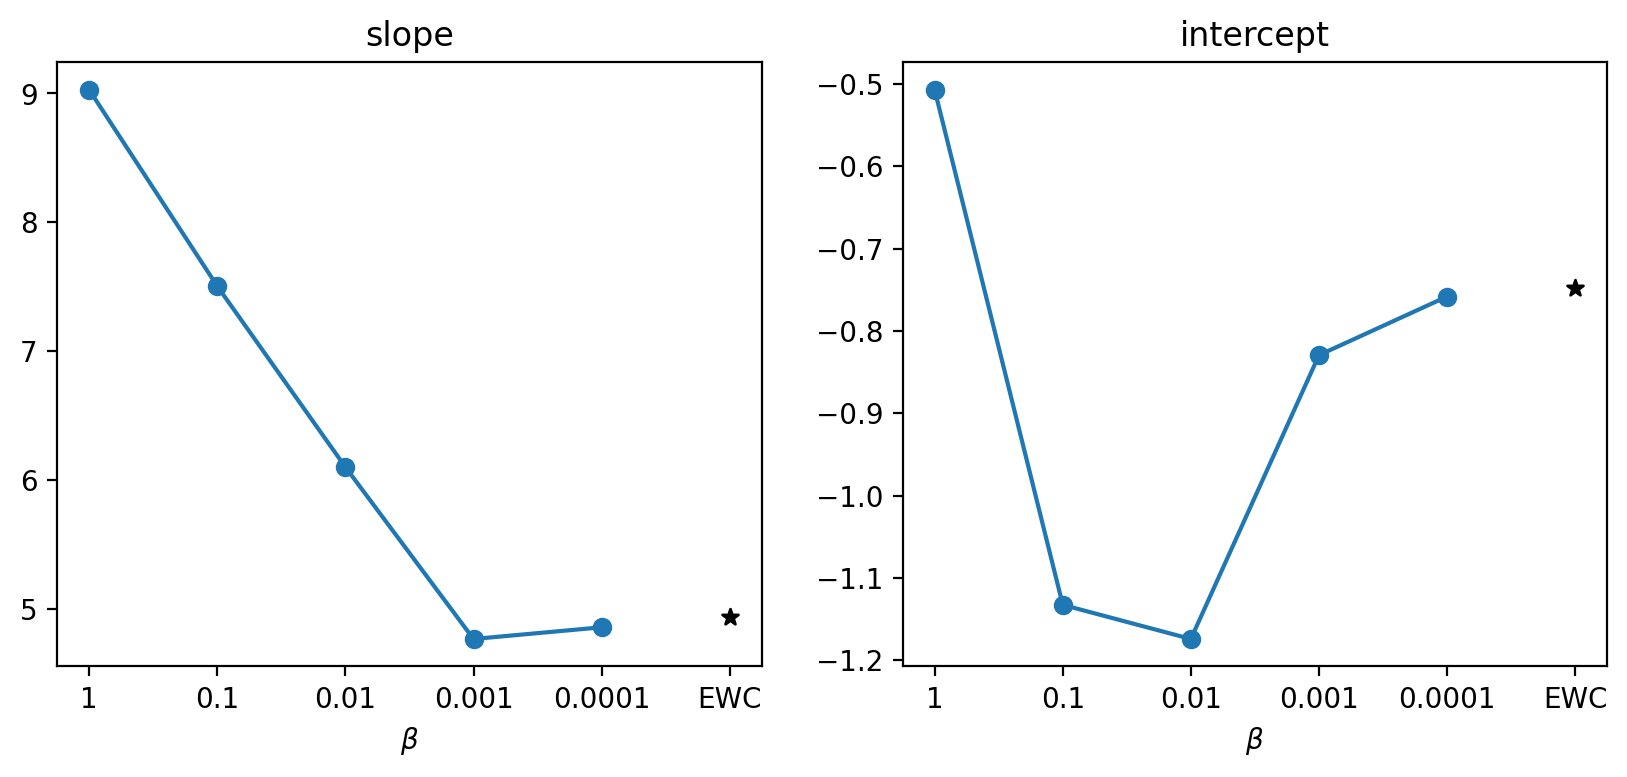

In [15]:
#plot slope/intercept

fig, ax = plt.subplots(1, 2, figsize=(10,4), dpi = 200)
    
ax[0].plot(np.arange(1, len(betas) + 1), results_mean[:-1, 0], marker = 'o')
ax[1].plot(np.arange(1, len(betas) + 1), results_mean[:-1, 1], marker = 'o')

ax[0].scatter(len(betas) + 1, results_mean[-1, 0], color = 'k', marker = '*')
ax[1].scatter(len(betas) + 1, results_mean[-1, 1], color = 'k', marker = '*')

ax[0].set_xticks(np.arange(1, len(betas) + 2))
ax[0].set_xticklabels(list(reversed(betas)) + ['EWC'])
ax[1].set_xticks(np.arange(1, len(betas) + 2))
ax[1].set_xticklabels(list(reversed(betas)) + ['EWC'])

ax[0].set_xlabel(r'$\beta$')
ax[1].set_xlabel(r'$\beta$')

ax[0].set_title('slope')
ax[1].set_title('intercept')


Text(0.5, 1.0, '$b$')

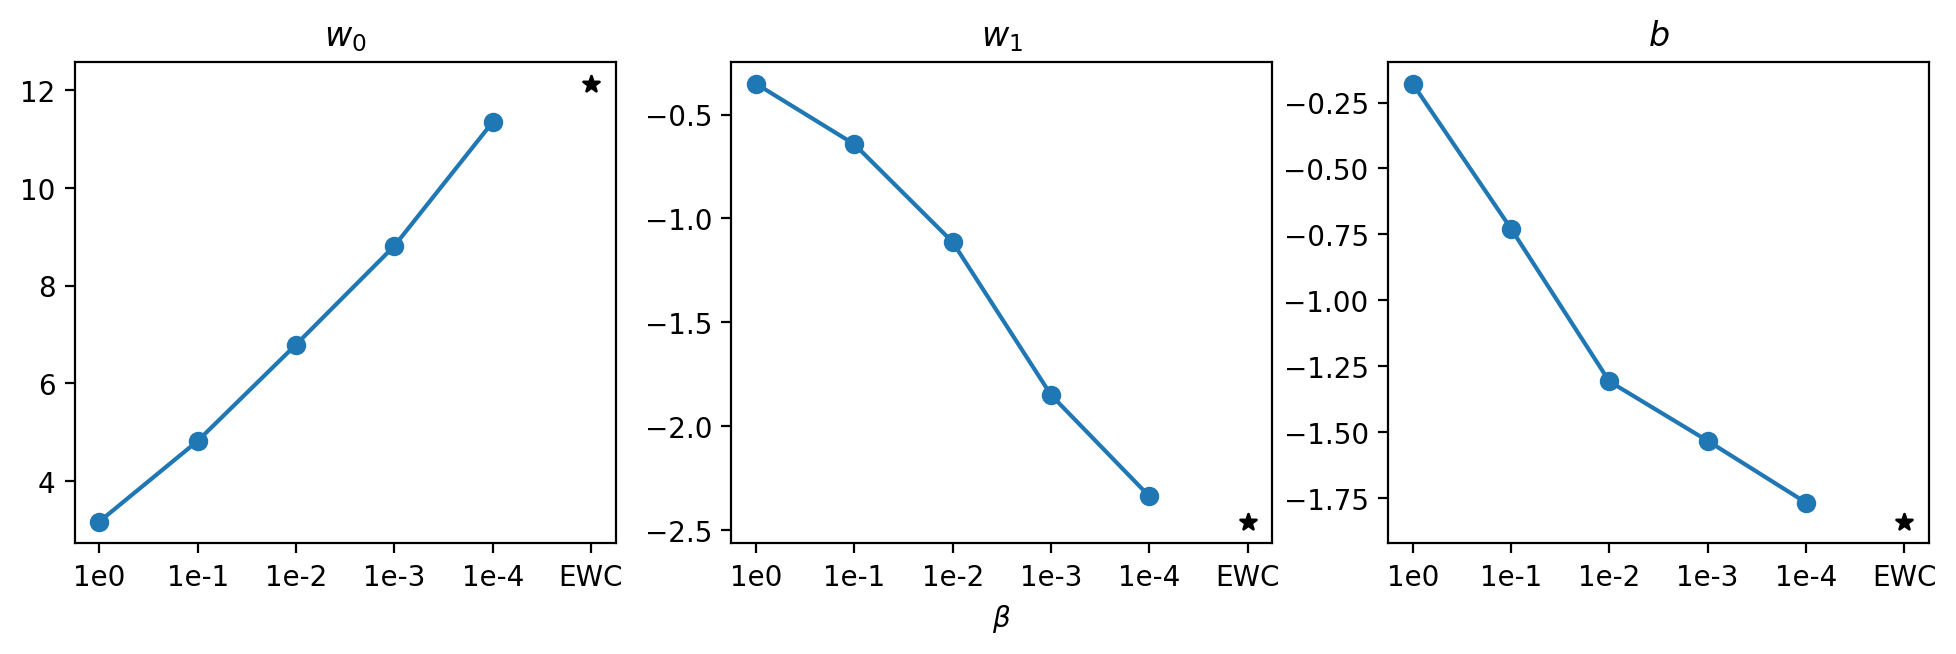

In [16]:
#plot parameter values

fig, ax = plt.subplots(1, 3, figsize=(10,3), dpi = 200)
plt.tight_layout()

ax[0].plot(np.arange(1, len(betas) + 1), results_mean[:-1, 2], marker = 'o')
ax[1].plot(np.arange(1, len(betas) + 1), results_mean[:-1, 3], marker = 'o')
ax[2].plot(np.arange(1, len(betas) + 1), results_mean[:-1, 4], marker = 'o')

ax[0].scatter(len(betas) + 1, results_mean[-1, 2], color = 'k', marker = '*')
ax[1].scatter(len(betas) + 1, results_mean[-1, 3], color = 'k', marker = '*')
ax[2].scatter(len(betas) + 1, results_mean[-1, 4], color = 'k', marker = '*')


beta_labels = ['1e0', '1e-1', '1e-2', '1e-3', '1e-4']

ax[0].set_xticks(np.arange(1, len(betas) + 2))
ax[0].set_xticklabels(beta_labels+ ['EWC'])
ax[1].set_xticks(np.arange(1, len(betas) + 2))
ax[1].set_xticklabels(beta_labels + ['EWC'])
ax[2].set_xticks(np.arange(1, len(betas) + 2))
ax[2].set_xticklabels(beta_labels + ['EWC'])

ax[1].set_xlabel(r'$\beta$')

ax[0].set_title(r'$w_0$')
ax[1].set_title(r'$w_1$')
ax[2].set_title(r'$b$')